In [1]:
%load_ext autoreload
%autoreload 2
import os
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from parse_log import parse_log, parse_solver_settings

logging.basicConfig()
logger = logging.getLogger()

errors = 'raise'

plot_stepsizes = True
plot_snapshots = True

In [59]:
input_log_files = ['../log/caffe.INFO']  # points always to the latest logfile

dftrain = {}
dftest = {}
for log_file in input_log_files:
    
    # check if log exists
    if not os.path.exists(log_file):
        if errors == 'raise':
            raise IOError('Could not find log file: {}.'.format(log_file))
        else:
            logger.warning('SKIP. Could not find log file: {}.'.format(log_file))
            
    # parse the raw log file
    trainlog, testlog = parse_log(log_file)
    solver = parse_solver_settings(log_file)
    
    # give this log a name
    logname = os.path.splitext(os.path.basename(log_file))[0]
    while logname in dftrain:
        logname += '_1' # make it unique
        
    # stuff it into a dataframe
    dftrain[logname] = pd.DataFrame(trainlog)
    dftest[logname] = pd.DataFrame(testlog)
    
# merge all logs to a MultiIndex DataFrame
dftrain = pd.concat(dftrain, names=['log', 'i'])
dftest = pd.concat(dftest, names=['log', 'i'])

is_multi_net = False
if 'NetId' in dftrain.columns:
    dftrain = dftrain.set_index('NetId', append=True).reorder_levels((0,2,1), axis=0)
if len(dftest) > 0 and 'NetId' in dftest.columns:
    dftest = dftest.set_index('NetId', append=True).reorder_levels((0,2,1), axis=0)
    is_multi_net = True

if 'class_acc_sum' in dftest.columns:
    dftest['class_acc_sum'] /= 6.

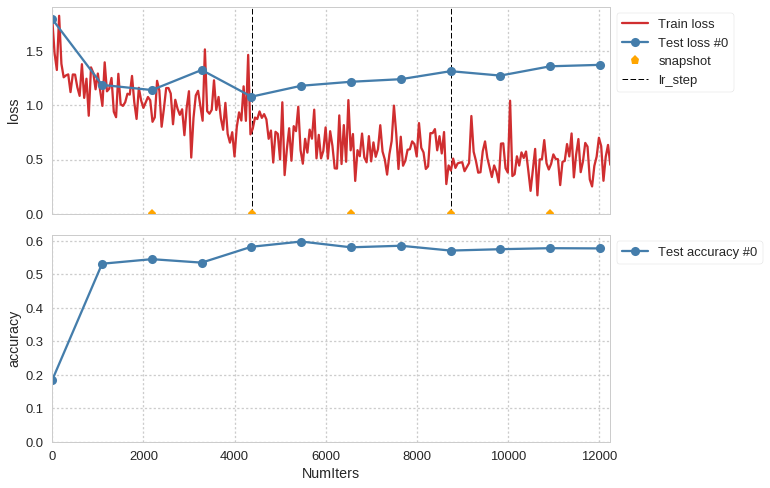

In [60]:
import matplotlib.ticker
sns.set('talk', style='whitegrid', rc={'grid.linestyle':':'})
n_test = len(dftest.index.get_level_values('log').unique()) * 1 if not is_multi_net else len(dftest.index.get_level_values('NetId').unique())
colors = sns.palettes.color_palette('Set1', n_colors=1+n_test, desat=.8)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10,8))
ax_loss = axs[0]
ax_acc = axs[1]

dftrain.groupby(level='log').plot(x='NumIters', y='loss', label='Train loss', color=colors[0], ax=ax_loss);
ax_loss.set_ylabel('loss')
ax_acc.set_ylabel('accuracy')
    
groupkeys = ['log'] + ['NetId'] if is_multi_net else []

if len(dftest) > 0:
    
    for i, (k, dfg) in enumerate(dftest.groupby(level=groupkeys)):
        icol = i+1
        dfg.plot(x='NumIters', y='loss', label='Test loss #{}'.format(k[1]), marker='o', 
                 ax=ax_loss, color=colors[icol])
        
        if 'accuracy' in dftest.columns:
            dfg.plot(x='NumIters', y='accuracy', label='Test accuracy #{}'.format(k[1]), marker='o', 
                     color=colors[icol], ax=ax_acc)

#     if 'class_acc_sum' in dftest.columns:
#         dftest.groupby(level=['log', 'NetId']).plot(x='NumIters', y='class_acc_sum', secondary_y=True, label='Avg Prec (class)', marker='v', ax=ax, mark_right=False);

ax_loss.set_xlim(0,dftrain.iloc[-1]['NumIters']);

ax_loss.set_ylim(0, );
ax_acc.set_ylim(0, );

# draw stepsizes
if plot_stepsizes:
    steps = np.arange(0, ax_loss.get_xlim()[1], solver['stepsize'], dtype=int)[1:]
    ax_loss.vlines(steps, *ax_loss.get_ylim(), linestyles='--', label='lr_step', linewidth=1)

# draw snapshots
if plot_snapshots:
    snapshots = np.arange(0, ax_loss.get_xlim()[1], solver['snapshot'], dtype=int)[1:]
    ax_loss.plot(snapshots, [0]*len(snapshots), linewidth=0, marker='p', color='orange', label='snapshot')

ax_loss.legend(loc='upper left', bbox_to_anchor=(1,1), frameon='fancy')
ax_acc.legend(loc='upper left', bbox_to_anchor=(1,1), frameon='fancy')

plt.subplots_adjust(hspace=.1)